In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# dataset: https://www.kaggle.com/datasets/barkhaverma/student-performance

In [128]:
# Importing and understanding of data.
data_names = ['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education','mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'final_grade' ]
data = pd.read_csv('/content/student-por.csv', sep=",")
data.columns = data_names
print(len(data.values))
print(data.dtypes)
data = data.drop_duplicates()
data.head(10)

649
school                         object
sex                            object
age                             int64
address                        object
family_size                    object
parent_cohabition_status       object
mother_education                int64
father_education                int64
mother_job                     object
father_job                     object
reason                         object
guardian                       object
traveltime                      int64
studytime                       int64
failures                        int64
school_support                 object
family_support                 object
paid                           object
extra_curricular_activities    object
nursery                        object
higher                         object
internet_access                object
romantic                       object
famrel                          int64
freetime                        int64
going_out                       int64
workday_

,school,sex,age,address,family_size,parent_cohabition_status,mother_education,father_education,mother_job,father_job,...,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


In [129]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

# the final grade seems to be most negatively correlated with number of failures in past classes and also weekday alcohol consumption
# it seems to be most positively correlated with studytime, mother's education (almost as much as studytime!), but mainly grades from previos periods. 

,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade
age,1.00,-0.11,-0.12,0.03,-0.01,0.32,-0.02,-0.00,0.11,0.13,0.09,-0.01,0.15,-0.17,-0.11,-0.11
mother_education,-0.11,1.00,0.65,-0.27,0.10,-0.17,0.02,-0.02,0.01,-0.01,-0.02,0.00,-0.01,0.26,0.26,0.24
father_education,-0.12,0.65,1.00,-0.21,0.05,-0.17,0.02,0.01,0.03,0.00,0.04,0.04,0.03,0.22,0.23,0.21
traveltime,0.03,-0.27,-0.21,1.00,-0.06,0.10,-0.01,0.00,0.06,0.09,0.06,-0.05,-0.01,-0.15,-0.15,-0.13
studytime,-0.01,0.10,0.05,-0.06,1.00,-0.15,-0.00,-0.07,-0.08,-0.14,-0.21,-0.06,-0.12,0.26,0.24,0.25
failures,0.32,-0.17,-0.17,0.10,-0.15,1.00,-0.06,0.11,0.05,0.11,0.08,0.04,0.12,-0.38,-0.39,-0.39
famrel,-0.02,0.02,0.02,-0.01,-0.00,-0.06,1.00,0.13,0.09,-0.08,-0.09,0.11,-0.09,0.05,0.09,0.06
freetime,-0.00,-0.02,0.01,0.00,-0.07,0.11,0.13,1.00,0.35,0.11,0.12,0.08,-0.02,-0.09,-0.11,-0.12
going_out,0.11,0.01,0.03,0.06,-0.08,0.05,0.09,0.35,1.00,0.25,0.39,-0.02,0.09,-0.07,-0.08,-0.09
workday_alcohol,0.13,-0.01,0.00,0.09,-0.14,0.11,-0.08,0.11,0.25,1.00,0.62,0.06,0.17,-0.20,-0.19,-0.20


In [130]:
# We can see that the final grade is highly correlated with grades in other period.
# Since these are very simular, we remove these columns too not get overly optimistic results on the algorithm. 
data = data.drop(['grade_period1', 'grade_period2'], axis=1)

In [131]:
data=data.replace(r'^\s*$', np.nan, regex=True)   # transform all whitespaces to NaNs.
print(data.isnull().values.any())    # checking so there isn't any NaNs in the data.

False


In [132]:
numerical_columns = ['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences']
target = ['final_grade']
# there are 14 numerical attributes.  

In [151]:
# Get the dummies so that it is easier to work. 
# This is, transform the categorical columns into numerical ones.

# categorical_columns = data.select_dtypes('object')
categorical_columns = ['school', 'sex', 'family_size', 'parent_cohabition_status', 'mother_job', 'father_job', 'reason', 'guardian', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic']

"""data = pd.get_dummies(data, drop_first=True)
data.columns
data.describe()

# Transform the data. 
# we need to standarize the data to take into consideration variations in measurments, units and scales. 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_columns])
scaled_dataframe = pd.DataFrame(scaled_data, columns = numerical_columns)  
print(scaled_dataframe.columns)
scaled_dataframe.head()

for column in numerical_columns:
  data.append(scaled_dataframe[column])
  data[column] = scaled_dataframe[column]

data"""
     

'data = pd.get_dummies(data, drop_first=True)\ndata.columns\ndata.describe()\n\n# Transform the data. \n# we need to standarize the data to take into consideration variations in measurments, units and scales. \nscaler = StandardScaler()\nscaled_data = scaler.fit_transform(data[numerical_columns])\nscaled_dataframe = pd.DataFrame(scaled_data, columns = numerical_columns)  \nprint(scaled_dataframe.columns)\nscaled_dataframe.head()\n\nfor column in numerical_columns:\n  data.append(scaled_dataframe[column])\n  data[column] = scaled_dataframe[column]\n\ndata'

In [134]:
"""corr = data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)"""

"corr = data.corr()\ncorr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)"

In [135]:
# these features seem to have the highest correlation with final_grade
# print(corr.abs().nlargest(5, 'final_grade').index)

In [250]:
# alpha_values = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alphas = np.arange(0,1,0.001).tolist()
def best_alpha(X, y, alpha_values=alphas):
    """
    Here we can test which the best alpha value is, using cross-validation for Lasso model.

    X is a feature matrix and y is a target vector. We will test all alpha values in the list of alpha values.
    """
    
    lasso = LassoCV(alphas=alpha_values, cv=5, random_state=42)
    lasso.fit(X, y)
    
    best_alpha = lasso.alpha_
    
    return best_alpha

In [163]:
X_encoded = data.drop("final_grade", axis=1)
y_encoded = data["final_grade"]

In [251]:
# Lasso Regression is a popular type of regularized linear regression that includes an L1 penalty.
# This penalty allows some coefficient values to go to the value of zero, allowing input variables to be effectively removed from the model, providing a type of automatic feature selection.

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1) 

# We will also divide into a validation set to choose models based on
X_train_encoded, X_val, y_train_encoded, y_val = train_test_split(X_train_encoded, y_train_encoded, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2 


categorical_columns = X_train_encoded.select_dtypes(include=['object']).columns

# Perform one-hot encoding on categorical columns
X_train_encoded = pd.get_dummies(X_train_encoded, columns=categorical_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_columns, drop_first=True)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_encoded[numerical_columns])
scaled_dataframe = pd.DataFrame(scaled_data, columns=numerical_columns)
for column in numerical_columns:
    X_train_encoded[column] = scaled_dataframe[column].values
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

X_train_encoded = X_train_encoded.dropna()   # remove rows with NaN values
X_val = X_val.dropna()

for feature in X_train_encoded.columns:
  if X_train_encoded[feature].dtype == 'float64':
    X_train_encoded[feature] = X_train_encoded[feature].astype(int)

print(X_train_encoded.dtypes, '\n')

best_alpha = best_alpha(X_train_encoded, y_train_encoded)

print("Alpha value we will use:", best_alpha)

lasso_model_total = Lasso(alpha=0.045)  # A LASSO model with all the features

lasso_model_total.fit(X_train_encoded, y_train_encoded)
yhat_tot_lasso = lasso_model_total.predict(X_val)    # the prediction
print(yhat_tot_lasso)

age                                int64
mother_education                   int64
father_education                   int64
traveltime                         int64
studytime                          int64
failures                           int64
famrel                             int64
freetime                           int64
going_out                          int64
workday_alcohol                    int64
weekend_alcohol                    int64
health                             int64
absences                           int64
school_MS                          uint8
sex_M                              uint8
address_U                          uint8
family_size_LE3                    uint8
parent_cohabition_status_T         uint8
mother_job_health                  uint8
mother_job_other                   uint8
mother_job_services                uint8
mother_job_teacher                 uint8
father_job_health                  uint8
father_job_other                   uint8
father_job_servi

In [252]:
# Let's evaluate how well the model did

mse_tot = mean_squared_error(y_val, yhat_tot_lasso)   

print("Mean squared error on validation set: %.10f" % mse_tot)

rmse_tot = mean_squared_error(y_val, yhat_tot_lasso, squared = False)  

print("Root mean squared error on validation set: %.10f" % rmse_tot)  # RMSE measures the average difference between values predicted by a model and the actual values.
# The lower the RMSE, the better a given model is able to “fit” a dataset.

r2_tot_score = r2_score(y_val, yhat_tot_lasso)   # Coefficient of determination. Best possible r2 score is 1.0. The R^2 score is a measure of how well the regression model explains the variance in the data
print("R^2 score on the validation set: %.10f" % r2_tot_score)

# These scores are pretty bad, but we might improve the accuracy with feature selection


Mean squared error on validation set: 9.1557257372
Root mean squared error on validation set: 3.0258429796
R^2 score on the validation set: 0.1276623390


39


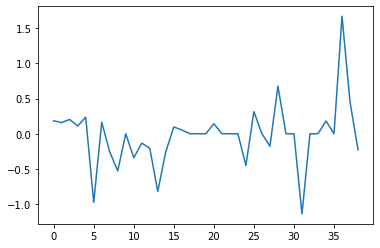


These features are chosen:

['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education', 'mother_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'higher', 'freetime', 'going_out', 'weekend_alcohol', 'health']

These features will be removed:

['father_job', 'paid', 'extra_curricular_activities', 'nursery', 'internet_access', 'romantic', 'famrel', 'workday_alcohol', 'absences', 'final_grade']


In [253]:
coefficients = lasso_model_total.coef_
print(len(coefficients))
plt.plot(range(len(coefficients)), coefficients)
plt.show()
chosen_features = []
removed_features = []

for i in range(31):
    if coefficients[i] != 0:
        chosen_features.append(data.columns[i])
    else:
        removed_features.append(data.columns[i])

print('\n' + 'These features are chosen:' + '\n')
print(chosen_features)

print('\n' + 'These features will be removed:' + '\n')
print(removed_features)

In [254]:
print(chosen_features)
X_sel = data[chosen_features]
y_sel = data["final_grade"]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.2, random_state=1) 

X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(X_train_sel, y_train_sel, test_size=0.25, random_state=1)

selected_categorical = X_train_sel.select_dtypes(include=['object']).columns
selected_numerical = X_train_sel.select_dtypes(include=['int']).columns


# Perform one-hot encoding on categorical columns
X_train_sel = pd.get_dummies(X_train_sel, columns=selected_categorical, drop_first=True)
X_val_sel = pd.get_dummies(X_val_sel, columns=selected_categorical, drop_first=True)

scaler_sel = StandardScaler()
scaled_sel_data = scaler.fit_transform(X_train_sel[selected_numerical])

scaled_sel_dataframe = pd.DataFrame(scaled_sel_data, columns=selected_numerical)

for column in selected_numerical:
    X_train_sel[column] = scaled_sel_dataframe[column].values
X_val_sel[selected_numerical] = scaler.transform(X_val_sel[selected_numerical])

X_train_sel = X_train_sel.dropna()   # remove rows with NaN values
X_val_sel = X_val_sel.dropna()

lasso_model_selected = Lasso(alpha=0.004) 

lasso_model_selected.fit(X_train_sel, y_train_sel)
yhat_from_selection = lasso_model_selected.predict(X_val_sel)    # the prediction
print(yhat_from_selection)

['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education', 'mother_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'higher', 'freetime', 'going_out', 'weekend_alcohol', 'health']
[11.85663228 13.01530472 11.83433053 13.57382853 15.26818716 12.84315627
 12.23098801 12.16697236 11.42042336  8.77112554  9.92768385 12.03177889
 11.90385807  7.43374809 13.26935847 13.52903046 12.73552276 12.17165285
 13.05330474 12.72152271 10.9258105  11.06336794 13.0138232  10.60039706
  8.99731858 15.01453253 11.72405407 13.87018057  9.43748697 14.95174547
 13.72486046  7.28729232 11.40600202 13.11963787 11.0466739  10.97000443
 13.13967347 12.40156293 13.74782392 10.87008972  9.9809617  13.70262446
  9.9648194  13.1127371  13.84935225 13.31746607 10.13376094 11.79134394
 14.21427039 11.74123049 13.05596534 10.59142954 12.633495   11.98853645
 14.4110151  12.23119267 11.78325383 11.84075972 

In [255]:
# Let's evaluate how well the model did again

mse_tot = mean_squared_error(y_val_sel, yhat_from_selection)   

print("Mean squared error on validation set: %.10f" % mse_tot)

rmse_tot = mean_squared_error(y_val_sel, yhat_from_selection, squared = False)  

print("Root mean squared error on validation set: %.10f" % rmse_tot)  # RMSE measures the average difference between values predicted by a model and the actual values.
# The lower the RMSE, the better a given model is able to “fit” a dataset.

r2_tot_score = r2_score(y_val_sel, yhat_from_selection)   # Coefficient of determination. Best possible r2 score is 1.0
print("R^2 score on the validation set: %.10f" % r2_tot_score)

# We see that we got a better accuracy after the feature selection, yay!

Mean squared error on validation set: 8.1173399268
Root mean squared error on validation set: 2.8490945802
R^2 score on the validation set: 0.2265974835


In [256]:
# After tuning the model to the validation set, we need to test its accuracy on unseen data.

X_test_sel = pd.get_dummies(X_test_sel, columns=selected_categorical, drop_first=True)
X_test_sel[selected_numerical] = scaler.transform(X_test_sel[selected_numerical])

new_pred = lasso_model_selected.predict(X_test_sel) 
mse_test = mean_squared_error(y_test_sel, new_pred)
print("Mean squared error on test set: %.10f" % mse_test)

rmse_test = mean_squared_error(y_test_sel, new_pred, squared = False)  

print("Root mean squared error on test set: %.10f" % rmse_test)  

r2_score_test = r2_score(y_test_sel, new_pred)   
print("R^2 score on the test set: %.10f" % r2_score_test)

Mean squared error on test set: 10.8519172050
Root mean squared error on test set: 3.2942248261
R^2 score on the test set: 0.1920427828


In [225]:
X_lr = data.drop("final_grade", axis=1)
y_lr = data["final_grade"]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=1) 

# We will also divide into a validation set to choose models based on
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_lr, y_lr, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

prediction = lr_model.predict(X_val_lr)


ValueError: ignored

In [ ]:
# Let's evaluate how well the model did

mse_lr = mean_squared_error(y_val_lr, prediction)   

print("Mean squared error on validation set: %.10f" % mse_lr)

rmse_lr = mean_squared_error(y_val_lr, prediction, squared = False)  

print("Root mean squared error on validation set: %.10f" % rmse_lr)  


r2_tot_lr = r2_score(y_val_lr, prediction)  
print("R^2 score on the validation set: %.10f" % r2_tot_lr)

# The Lasso model had slightly lower mean squared error, which indicates a better fit.
# However, the Linear regression model has a higher R^2 score, which might indicate a better fit.